# Data Load & Cleansing

In [1]:
# load package
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# load data
accepted_raw = pd.read_csv('./data/accepted_2007_to_2018Q4.csv', low_memory=False)
print(accepted_raw.shape)

# save description for NLP
accepted_raw[['id', 'loan_status', 'desc']].to_csv('./data/desc.csv', index=False)

(2260701, 151)


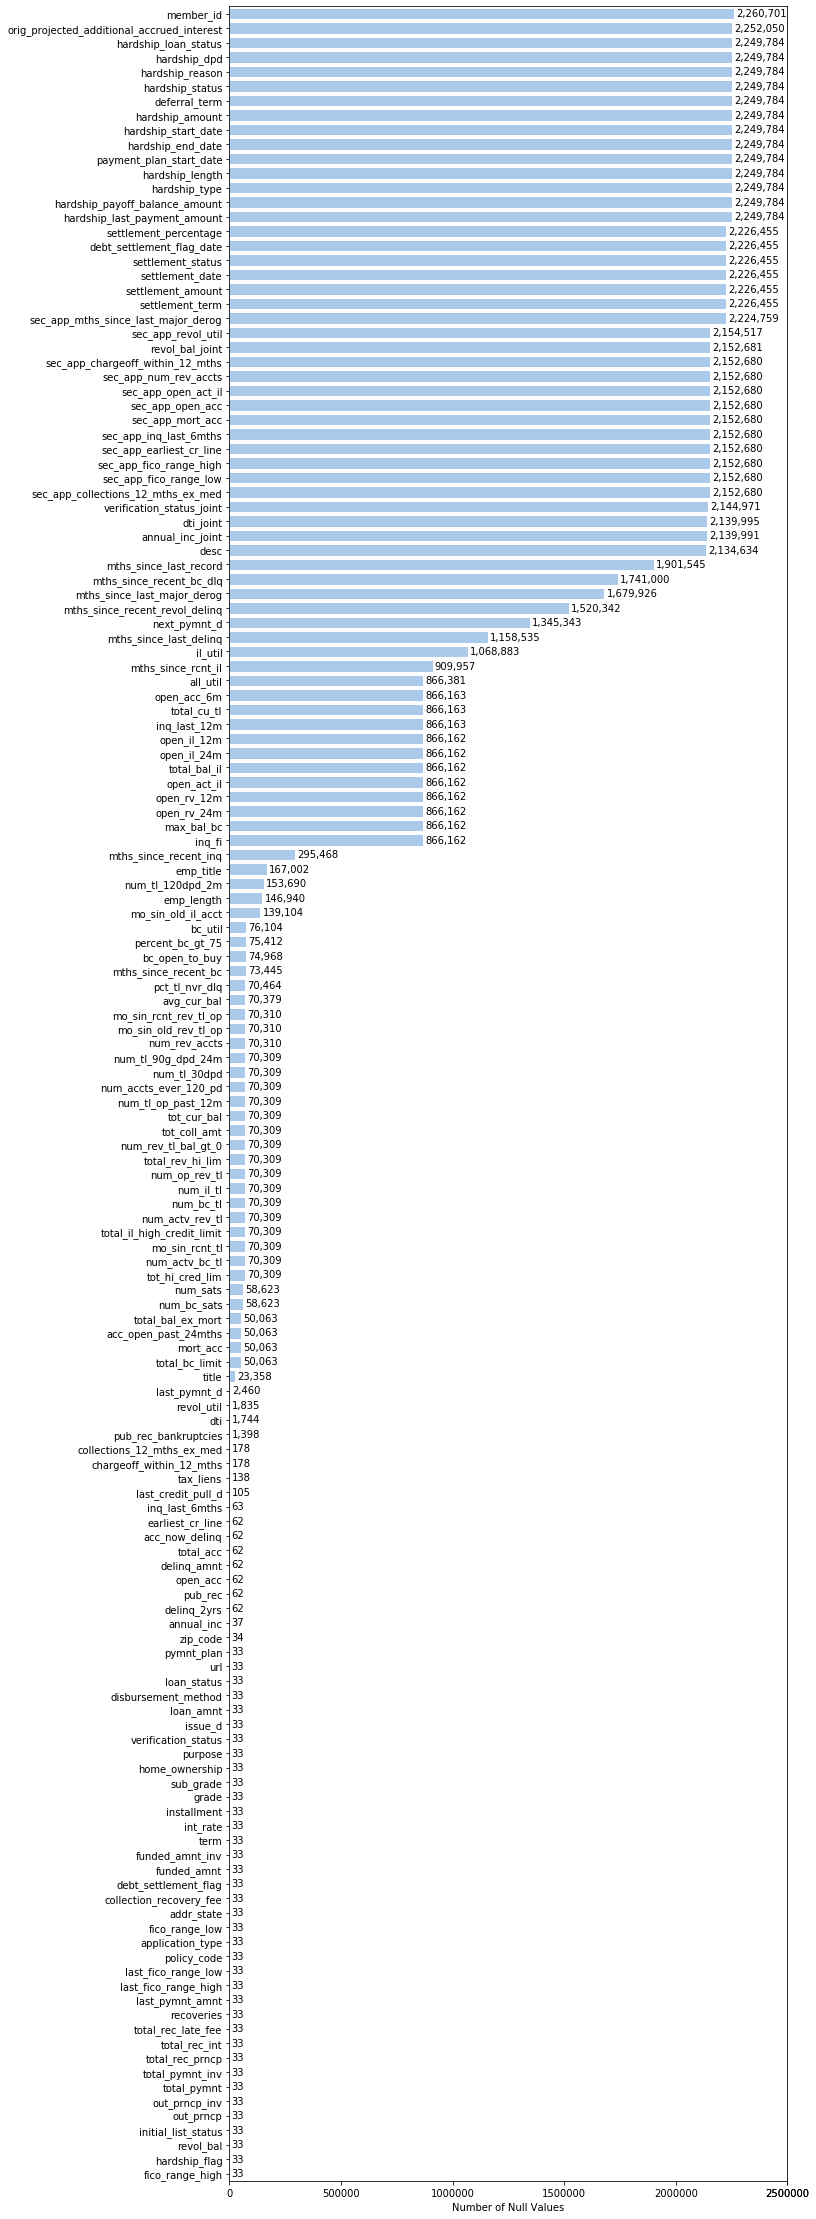

In [3]:
# check null count & visualization
null_x = []
null_y = []

col_null_cnt = accepted_raw.isnull().sum().sort_values(ascending=False)
for k, v in col_null_cnt.iteritems():
    if v > 0:
        null_x = null_x + [k]
        null_y = null_y + [v]

plt.figure(figsize=(10, 40))
sns.set_color_codes('pastel')
sns.barplot(x = null_y, y = null_x, label = 'Count', color = 'b', edgecolor = 'w')
plt.xticks(list(plt.xticks()[0]) + [2500000])
plt.xlabel("Number of Null Values")

for x, y in zip(range(0, len(null_y)), null_y):
    plt.text(y + 10000, x + 0.2, format(y, ',d'))

plt.show()

In [4]:
# drop useless column
accepted = accepted_raw.drop(['member_id', 'id', 'desc', 'url'], axis=1)

# remove wrong parsed rows (33 rows)
accepted = accepted[~accepted['grade'].isnull()]

# filtering before 2013
accepted = accepted.assign(issue_d=pd.to_datetime(accepted['issue_d'], format='%b-%Y'))
accepted = accepted[accepted['issue_d'] >= '2013-01-01']

# convert lower case
accepted['emp_title'] = accepted['emp_title'].str.lower()
accepted['title'] = accepted['title'].str.lower()

# drop missing column (>= 50%)
# related to hardship, settlement, secondary applicant
drop_cols = []
col_null_cnt = accepted.isnull().sum()
for k, v in col_null_cnt.iteritems():
    if v >= (len(accepted) / 2):
        drop_cols = drop_cols + [k]

print('drop missing column (>= 50%):')
print(drop_cols)

accepted = accepted.drop(drop_cols, axis=1)

# imputation
accepted['title'] = accepted['title'].replace(np.NaN, 'unknown')
accepted['emp_title'] = accepted['emp_title'].replace(np.NaN, 'unknown')
accepted['emp_length'] = pd.to_numeric(accepted['emp_length'].str.replace(' years|year|\+', '').str.replace('< 1', '0'))
accepted['emp_length'] = accepted['emp_length'] + 1 # shift range
accepted['emp_length'] = accepted['emp_length'].replace(np.NaN, 0) # minimum new value

# imputation (1 record)
accepted['zip_code'] = accepted['zip_code'].replace(np.NaN, '35004') # state: AL
accepted['inq_last_6mths'] = accepted['inq_last_6mths'].replace(np.NaN, 0)
accepted['num_rev_accts'] = accepted['num_rev_accts'].replace(np.NaN, 3.0)

drop missing column (>= 50%):
['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_da

In [5]:
# imputation (IterativeImputer)
target_col = []
drop_cols = []

col_null_cnt = accepted.isnull().sum()
for k, v in col_null_cnt.iteritems():
    if v > 0:
        if accepted[k].dtype == 'float64':
            target_col = target_col + [k]
        else:
            drop_cols = drop_cols + [k]

accepted = accepted.drop(drop_cols, axis=1) # drop non numeric column
print('drop non numeric column (date):')
print(drop_cols)
print()

print('\ntarget columns for imputation:')
print(target_col)
print()

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(accepted[target_col])
print(imp)

imputed = imp.transform(accepted[target_col])
accepted[target_col] = imputed

drop non numeric column (date):
['last_pymnt_d', 'last_credit_pull_d']


target columns for imputation:
['dti', 'revol_util', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']



/Users/longhong/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, tol=0.001, verbose=0)


In [ ]:
# save imputed dataframe
# accepted.to_csv('./data/accepted_imputed.csv', index=False)

# load dataframe
accepted = pd.read_csv('./data/accepted_imputed.csv', low_memory=False)

In [6]:
pd.set_option('display.max_columns', 200)
accepted.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,11.0,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,debt_consolidation,debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.000000,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,engineer,11.0,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,small_business,business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.000000,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,11.0,MORTGAGE,63000.0,Not Verified,2015-12-01,Fully Paid,n,home_improvement,unknown,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.000000,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,information systems officer,11.0,MORTGAGE,110000.0,Source Verified,2015-12-01,Current,n,debt_consolidation,debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,10.728141,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,contract specialist,4.0,MORTGAGE,104433.0,Source Verifie

In [7]:
accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2164766 entries, 0 to 2260698
Columns: 103 entries, loan_amnt to debt_settlement_flag
dtypes: datetime64[ns](1), float64(84), object(18)
memory usage: 1.7+ GB


In [8]:
accepted.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2164766.0,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06,2.164766e+06
mean,1.516377e+04,1.516375e+04,1.515868e+04,1.309762e+01,4.488174e+02,6.493857e+00,7.837035e+04,1.898305e+01,3.125054e-01,6.982350e+02,7.022352e+02,5.606865e-01,1.168135e+01,2.044207e-01,1.674324e+04,5.018008e+01,2.421623e+01,4.393262e+03,4.392295e+03,1.200882e+04,1.200435e+04,9.442863e+03,2.420264e+03,1.531942e+00,1.441597e+02,2.440381e+01,3.441546e+03,6.877711e+02,6.757087e+02,1.893923e-02,1.0,4.322407e-03,2.349207e+02,1.426465e+05,9.268010e-01,2.796811e+00,6.711136e-01,1.553124e+00,2.195445e+01,3.544831e+04,6.625260e+01,1.280045e+00,2.726193e+00,5.960178e+03,5.865781e+01,3.464712e+04,1.011003e+00,1.484746e+00,2.060762e+00,4.534634e+00,1.355145e+04,1.137992e+04,5.768640e+01,8.801413e-03,1.285873e+01,1.253617e+02,1.816034e+02,1.402374e+01,8.292387e+00,1.554143e+00,2.494031e+01,7.360878e+00,5.022949e-01,3.676254e+00,5.630629e+00,4.777127e+00,7.709912e+00,8.423820e+00,8.250491e+00,1.399552e+01,5.578271e+00,1.163994e+01,6.423654e-04,2.842340e-03,8.317758e-02,2.079538e+00,9.410492e+01,4.217855e+01,1.323640e-01,4.882006e-02,1.785015e+05,5.125337e+04,2.326972e+04,4.385782e+04
std,9.226468e+03,9.226468e+03,9.224418e+03,4.859874e+00,2.680920e+02,3.994101e+00,1.144297e+05,1.438447e+01,8.772089e-01,3.289410e+01,3.289500e+01,8.612830e-01,5.675317e+00,5.803484e-01,2.312725e+04,2.461461e+01,1.201617e+01,7.449379e+03,7.448471e+03,9.885733e+03,9.882160e+03,8.340232e+03,2.658652e+03,1.200603e+01,7.477438e+02,1.311046e+02,6.057528e+03,7.259466e+01,1.106319e+02,1.540344e-01,0.0,7.106495e-02,8.568415e+03,1.607574e+05,9.535022e-01,2.429440e+00,7.540438e-01,1.281050e+00,2.092094e+01,3.615260e+04,1.928172e+01,1.267405e+00,2.195879e+00,4.889135e+03,1.859781e+01,3.683876e+04,1.219289

# Basic Statistics

/Users/longhong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


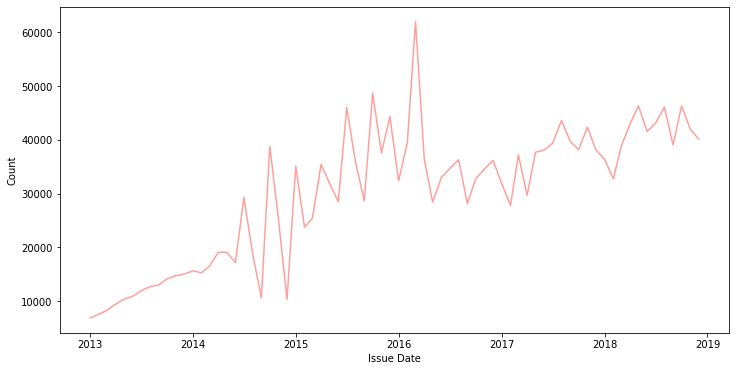

In [9]:
# analysis time series for interest rate (each grade)
count_dt = accepted.groupby(['issue_d']).aggregate({'loan_amnt':'count'})
count_dt = count_dt.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='loan_amnt', data=count_dt, color='r')

plt.xlabel("Issue Date")
plt.ylabel("Count")
plt.show()

- what happened to near 2016?

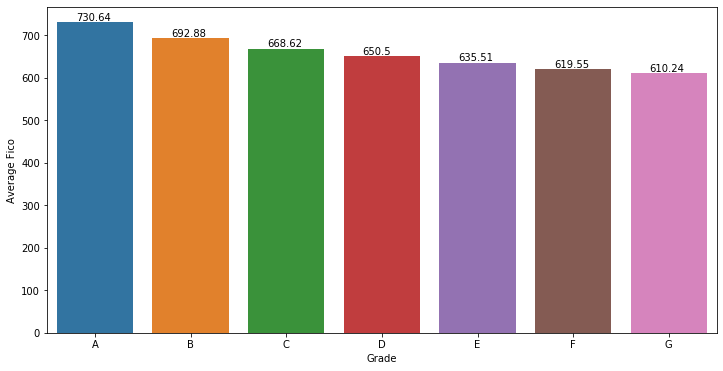

In [10]:
# analysis fico score for grade
fico_avg = (accepted['last_fico_range_high'] + accepted['last_fico_range_low']) / 2
grade_agg = accepted.assign(fico_avg=fico_avg).groupby(['grade']).aggregate({'fico_avg':'mean'})
grade_agg = grade_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='fico_avg', data=grade_agg)

plt.xlabel("Grade")
plt.ylabel("Average Fico")

for x, y in zip(range(0, 7), grade_agg['fico_avg']):
    plt.text(x - 0.2, y + 5, round(y, 2))

plt.show()

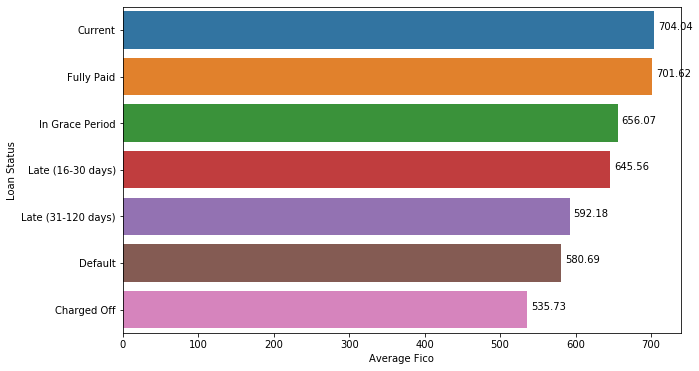

In [11]:
# analysis fico score for grade
grade_agg = accepted.assign(fico_avg=fico_avg).groupby(['loan_status']).aggregate({'fico_avg':'mean'})
grade_agg = grade_agg.reset_index().sort_values('fico_avg', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='loan_status', x='fico_avg', data=grade_agg)

plt.xlabel("Average Fico")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 9), grade_agg['fico_avg']):
    plt.text(y + 5, x, round(y, 2))

plt.show()

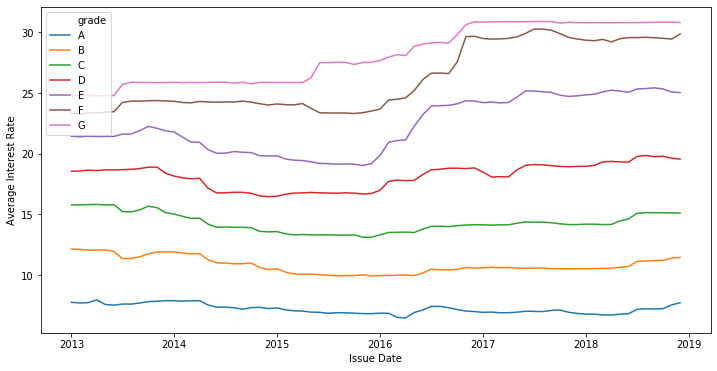

In [12]:
# analysis time series for interest rate (each grade)
int_rate_agg = accepted.groupby(['issue_d','grade']).aggregate({'int_rate':'mean'})
int_rate_agg = int_rate_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='int_rate', hue='grade', data=int_rate_agg)

plt.xlabel("Issue Date")
plt.ylabel("Average Interest Rate")
plt.show()

- Low grade(E, F, G) is getting higher interest rate.

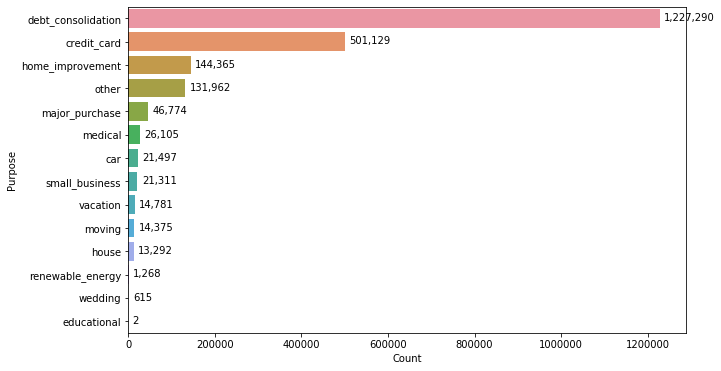

In [13]:
purpose_cnt = accepted['purpose'].value_counts().rename_axis('purpose').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='purpose', x='count', data=purpose_cnt)

plt.xlabel("Count")
plt.ylabel("Purpose")

for x, y in zip(range(0, 14), purpose_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

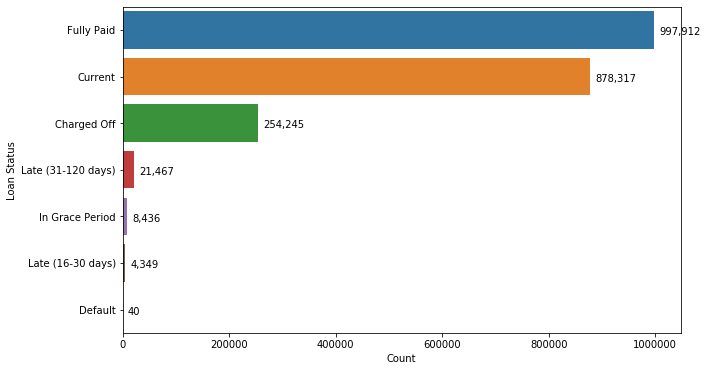

In [14]:
# imbalance (Fully Paid, Current)
status_cnt = accepted['loan_status'].value_counts().rename_axis('status').to_frame('count').reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='status', x='count', data=status_cnt)

plt.xlabel("Count")
plt.ylabel("Loan Status")

for x, y in zip(range(0, 14), status_cnt['count']):
    plt.text(y + 10000, x + 0.1, format(y, ',d'))

plt.show()

In [15]:
target_col = []
col_null_cnt = accepted.isnull().sum().sort_values(ascending=False)
for k, v in col_null_cnt.iteritems():
    if v == 0:
        if accepted[k].dtype == 'float64' and k != 'policy_code':
            target_col = target_col + [k]

corr = accepted[target_col].corr()

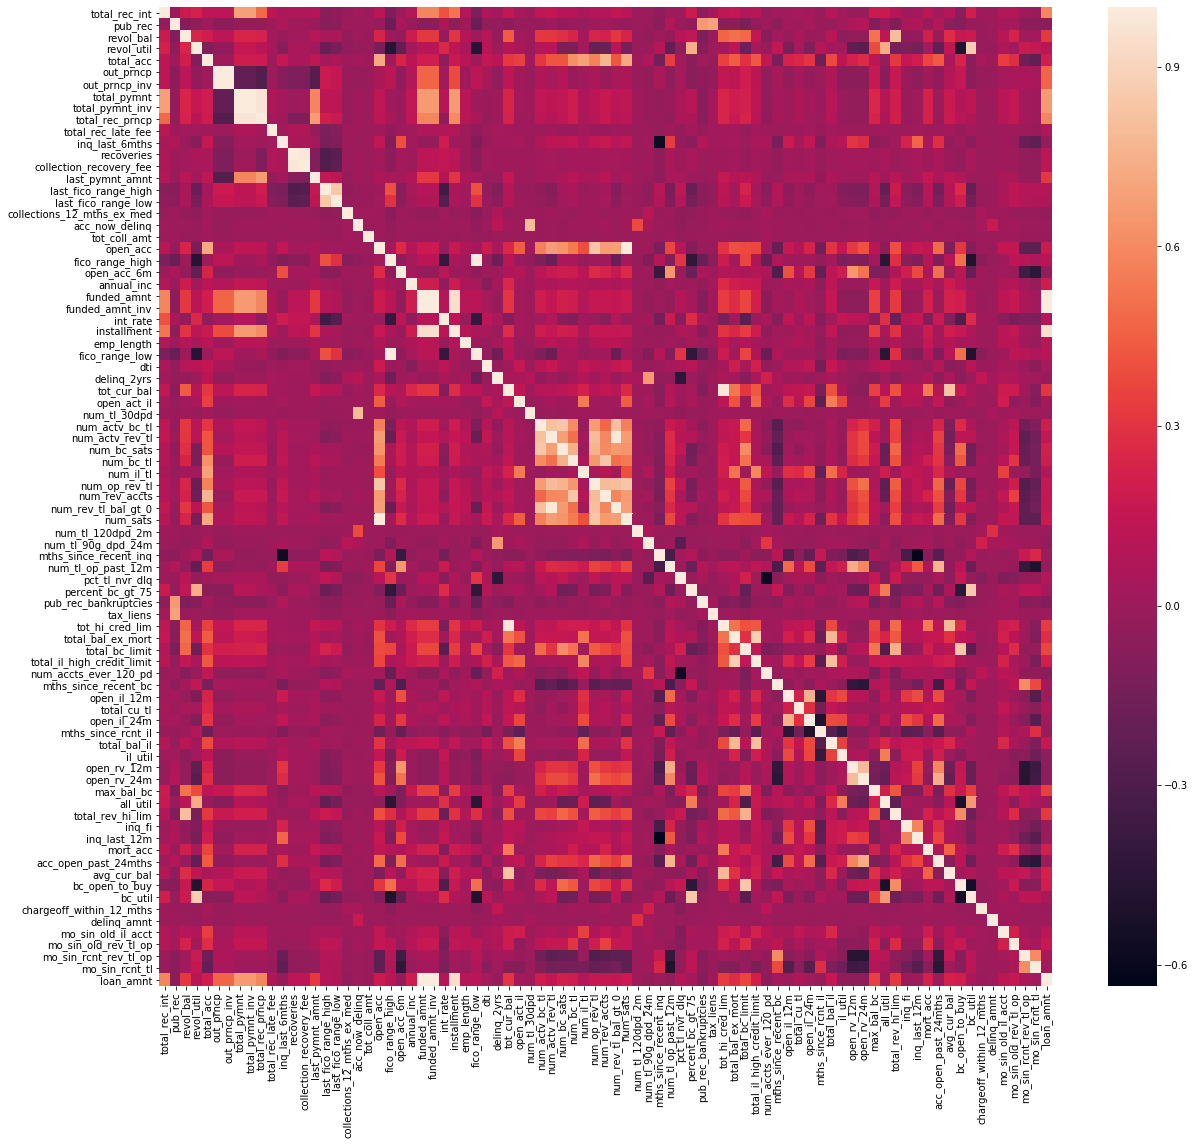

In [16]:
plt.figure(figsize=(20, 18))
sns.heatmap(corr)

# Default Rate Analysis

\begin{equation*}
Default Rate(\%) = \frac{Charged Off + Default}{Fully Paid + Charged Off + Default}
\end{equation*}

In [17]:
# create new data set for Fully Paid and (Charged Off + Default)
accepted_new = accepted[(accepted['loan_status'] == 'Fully Paid') | (accepted['loan_status'] == 'Charged Off') | (accepted['loan_status'] == 'Default')]
accepted_new = accepted_new.assign(paid_flag = np.where(accepted_new['loan_status'].str.contains('Fully Paid'), 1, 0))

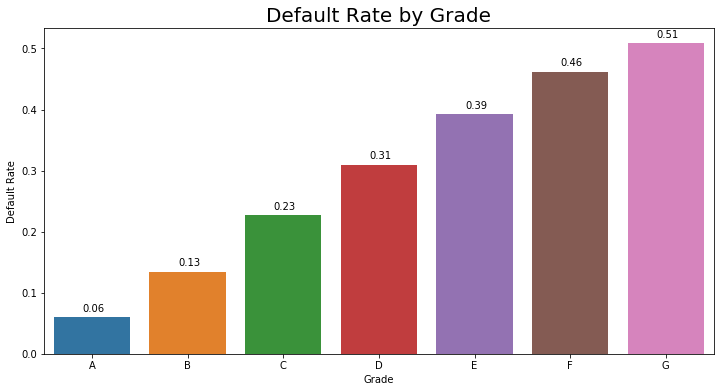

In [18]:
# default rate by grade
default_rate_grade = accepted_new.groupby(['grade']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_grade['paid_flag']['count'] - default_rate_grade['paid_flag']['sum']) / default_rate_grade['paid_flag']['count']
default_rate_grade = default_rate_grade.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='default_rate', data=default_rate_grade).set_title('Default Rate by Grade', fontsize=20)

plt.xlabel("Grade")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 7), default_rate_grade['default_rate']):
    plt.text(x - 0.1, y + 0.01, round(y, 2))

plt.show()

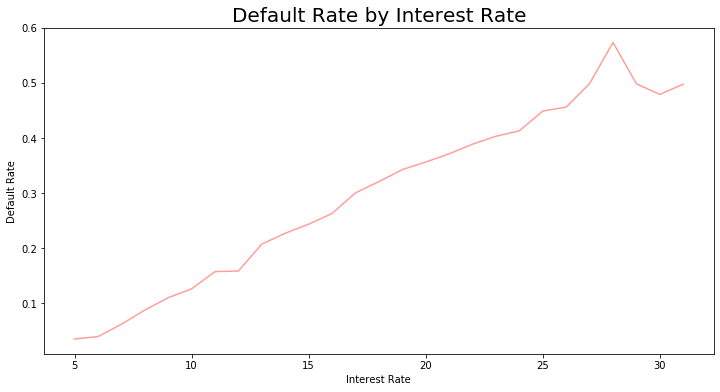

In [19]:
# default rate by interest rate
default_rate_int = accepted_new.assign(int_rate=round(accepted_new['int_rate'])).groupby('int_rate').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_int['paid_flag']['count'] - default_rate_int['paid_flag']['sum']) / default_rate_int['paid_flag']['count']
default_rate_int = default_rate_int.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='int_rate', y='default_rate', data=default_rate_int, color='r').set_title('Default Rate by Interest Rate', fontsize=20)

plt.xlabel("Interest Rate")
plt.ylabel("Default Rate")

plt.show()

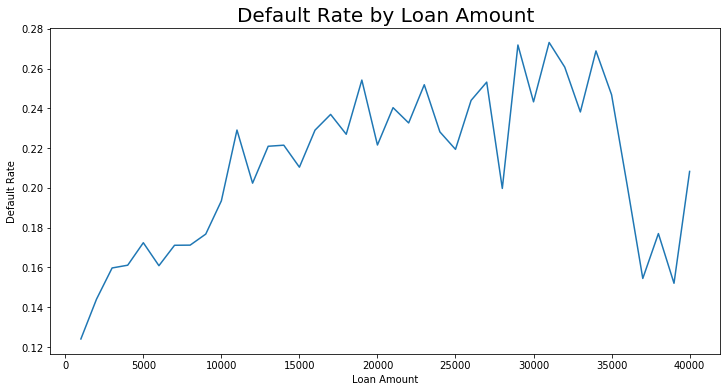

In [20]:
# default rate by Loan Amount
default_rate_loan = accepted_new.assign(loan_amnt=round(accepted_new['loan_amnt'], -3)).groupby('loan_amnt').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_loan['paid_flag']['count'] - default_rate_loan['paid_flag']['sum']) / default_rate_loan['paid_flag']['count']
default_rate_loan = default_rate_loan.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='loan_amnt', y='default_rate', data=default_rate_loan).set_title('Default Rate by Loan Amount', fontsize=20)

plt.xlabel("Loan Amount")
plt.ylabel("Default Rate")

plt.show()

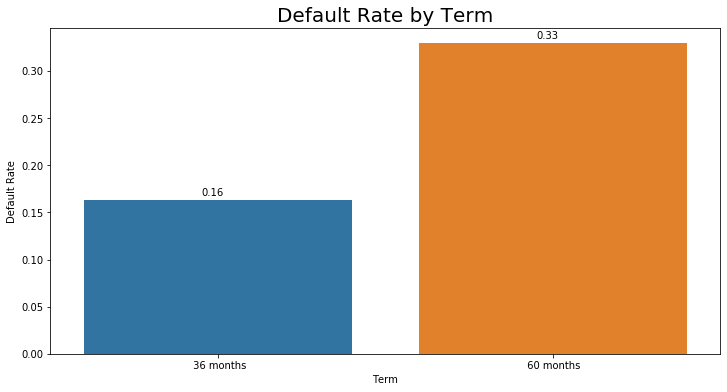

In [21]:
# default rate by term
default_rate_term = accepted_new.groupby(['term']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_term['paid_flag']['count'] - default_rate_term['paid_flag']['sum']) / default_rate_term['paid_flag']['count']
default_rate_term = default_rate_term.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.barplot(x='term', y='default_rate', data=default_rate_term).set_title('Default Rate by Term', fontsize=20)

plt.xlabel("Term")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 7), default_rate_term['default_rate']):
    plt.text(x - 0.05, y + 0.005, round(y, 2))

plt.show()

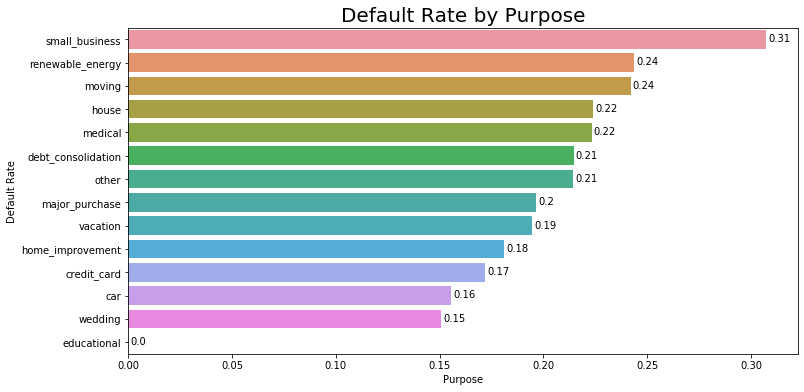

In [22]:
# default rate by purpose
default_rate_purpose = accepted_new.groupby(['purpose']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_purpose['paid_flag']['count'] - default_rate_purpose['paid_flag']['sum']) / default_rate_purpose['paid_flag']['count']
default_rate_purpose = default_rate_purpose.assign(default_rate=default_rate)
default_rate_purpose = default_rate_purpose.sort_values('default_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='default_rate', y='purpose', data=default_rate_purpose).set_title('Default Rate by Purpose', fontsize=20)

plt.xlabel("Purpose")
plt.ylabel("Default Rate")

for x, y in zip(range(0, 14), default_rate_purpose['default_rate']):
    plt.text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

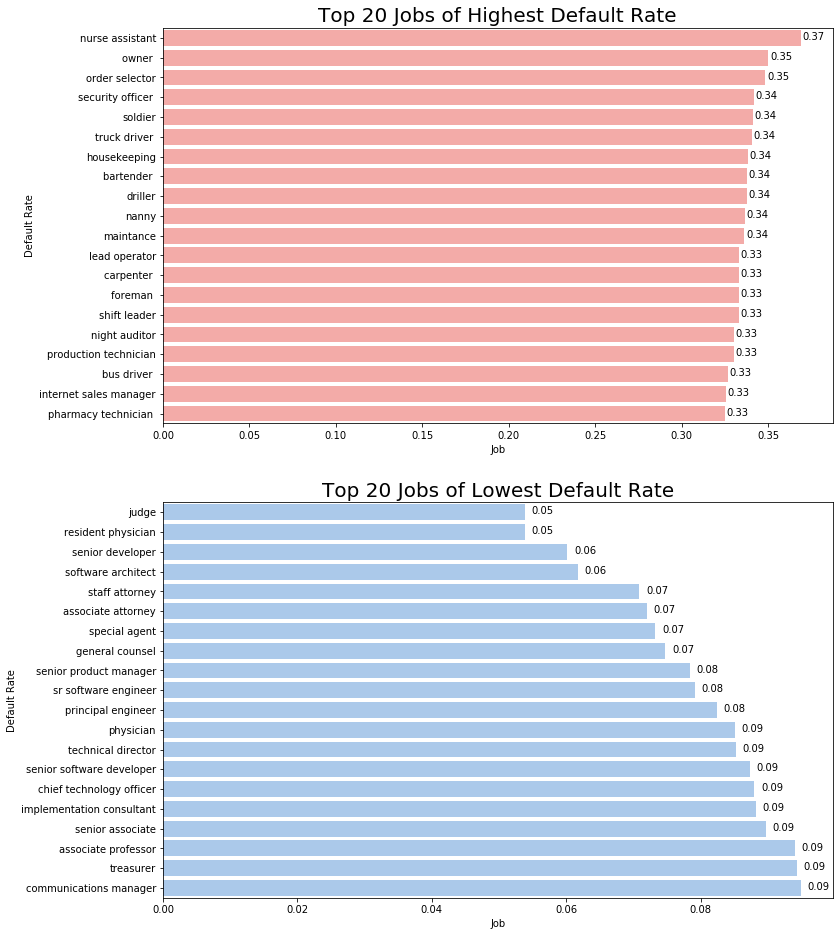

In [23]:
# default rate by job (Highest)
default_rate_emp = accepted_new.groupby(['emp_title']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate_emp.columns = ['emp_title', 'paid_sum', 'paid_count']
default_rate = (default_rate_emp['paid_count'] - default_rate_emp['paid_sum']) / default_rate_emp['paid_count']
default_rate_emp = default_rate_emp.assign(default_rate=default_rate)
default_rate_emp = default_rate_emp[default_rate_emp['paid_count'] > 100]
default_rate_emp_top20 = default_rate_emp.sort_values('default_rate', ascending=False).head(20)

fig, axs = plt.subplots(2, figsize=(12, 16))

sns.barplot(ax=axs[0], x='default_rate', y='emp_title', data=default_rate_emp_top20, color='r').set_title('Top 20 Jobs of Highest Default Rate', fontsize=20)

axs[0].set(xlabel='Job', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_emp_top20['default_rate']):
    axs[0].text(y + 0.001, x + 0.1, round(y, 2))


# default rate by job (Lowest)
default_rate_emp_bottom20 = default_rate_emp.sort_values('default_rate', ascending=True).head(20)

sns.barplot(ax=axs[1], x='default_rate', y='emp_title', data=default_rate_emp_bottom20, color='b').set_title('Top 20 Jobs of Lowest Default Rate', fontsize=20)

axs[1].set(xlabel='Job', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_emp_bottom20['default_rate']):
    axs[1].text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

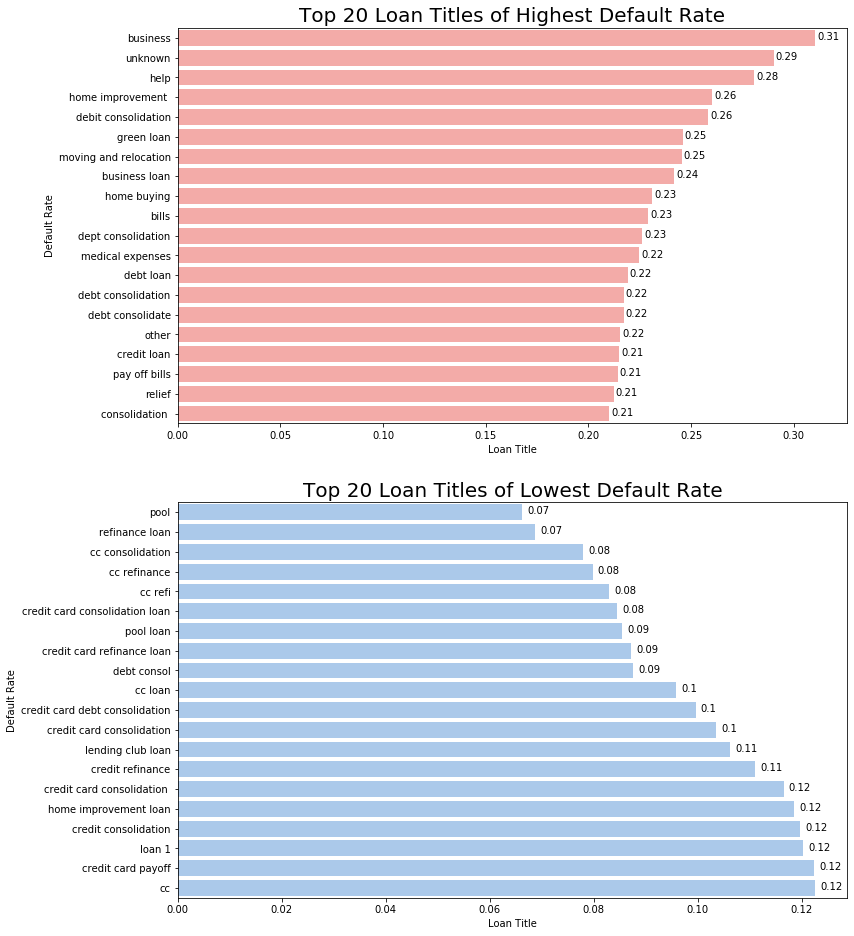

In [24]:
# default rate by loan title (Highest)
default_rate_title = accepted_new.groupby(['title']).aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate_title.columns = ['title', 'paid_sum', 'paid_count']
default_rate = (default_rate_title['paid_count'] - default_rate_title['paid_sum']) / default_rate_title['paid_count']
default_rate_title = default_rate_title.assign(default_rate=default_rate)
default_rate_title = default_rate_title[default_rate_title['paid_count'] > 100]
default_rate_title_top20 = default_rate_title.sort_values('default_rate', ascending=False).head(20)

fig, axs = plt.subplots(2, figsize=(12, 16))

sns.barplot(ax=axs[0], x='default_rate', y='title', data=default_rate_title_top20, color='r').set_title('Top 20 Loan Titles of Highest Default Rate', fontsize=20)

axs[0].set(xlabel='Loan Title', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_title_top20['default_rate']):
    axs[0].text(y + 0.001, x + 0.1, round(y, 2))


# default rate by loan title (Lowest)
default_rate_title_bottom20 = default_rate_title.sort_values('default_rate', ascending=True).head(20)

sns.barplot(ax=axs[1], x='default_rate', y='title', data=default_rate_title_bottom20, color='b').set_title('Top 20 Loan Titles of Lowest Default Rate', fontsize=20)

axs[1].set(xlabel='Loan Title', ylabel='Default Rate')

for x, y in zip(range(0, 20), default_rate_title_bottom20['default_rate']):
    axs[1].text(y + 0.001, x + 0.1, round(y, 2))

plt.show()

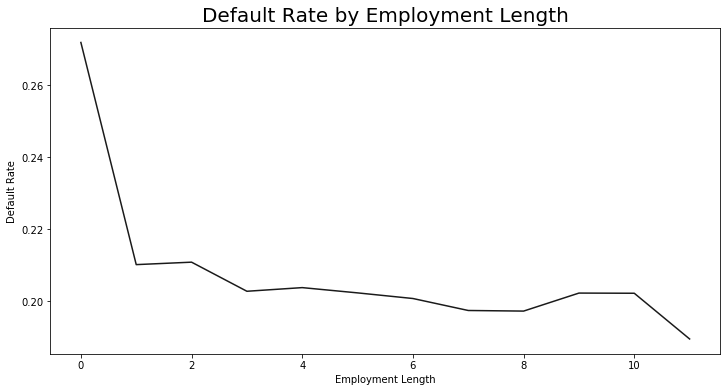

In [25]:
# default rate by employment length
default_rate_emp = accepted_new.groupby('emp_length').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_emp['paid_flag']['count'] - default_rate_emp['paid_flag']['sum']) / default_rate_emp['paid_flag']['count']
default_rate_emp = default_rate_emp.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='emp_length', y='default_rate', data=default_rate_emp, color='k').set_title('Default Rate by Employment Length', fontsize=20)

plt.xlabel("Employment Length")
plt.ylabel("Default Rate")

plt.show()

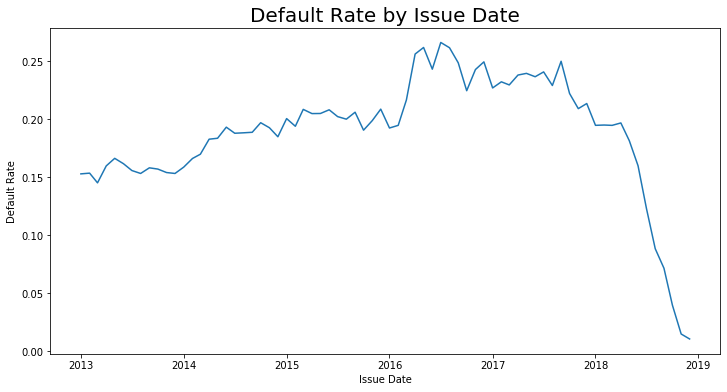

In [26]:
# default rate by Date
default_rate_dt = accepted_new.groupby('issue_d').aggregate({'paid_flag':['sum', 'count']}).reset_index()
default_rate = (default_rate_dt['paid_flag']['count'] - default_rate_dt['paid_flag']['sum']) / default_rate_dt['paid_flag']['count']
default_rate_dt = default_rate_dt.assign(default_rate=default_rate)

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='default_rate', data=default_rate_dt).set_title('Default Rate by Issue Date', fontsize=20)

plt.xlabel("Issue Date")
plt.ylabel("Default Rate")

plt.show()

# Invest Profit Analysis

\begin{equation*}
Profit Rate(\%) = \frac{Total Payment - Funded Amount}{Funded Amount}
\end{equation*}

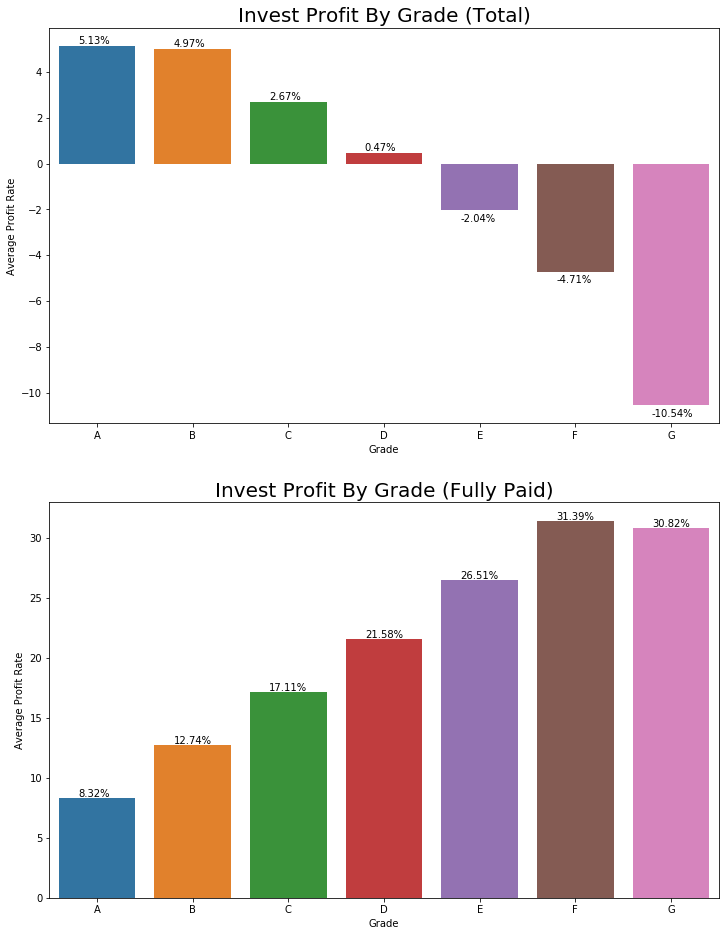

In [27]:
# invest profit by grade
profit_rate = (accepted_new['total_pymnt'] - accepted_new['funded_amnt']) / accepted_new['funded_amnt'] * 100
grade_agg = accepted_new.assign(profit_rate=profit_rate).groupby(['grade']).aggregate({'profit_rate':'mean'})
grade_agg = grade_agg.reset_index()

fig, axs = plt.subplots(2, figsize=(12, 16))

sns.barplot(ax=axs[0], x='grade', y='profit_rate', data=grade_agg).set_title('Invest Profit By Grade (Total)', fontsize=20)

axs[0].set(xlabel='Grade', ylabel='Average Profit Rate')

for x, y in zip(range(0, 7), grade_agg['profit_rate']):
    if y < 0:
        axs[0].text(x - 0.2, y - 0.5, str(round(y, 2)) + '%')
    else:
        axs[0].text(x - 0.2, y + 0.1, str(round(y, 2)) + '%')

accepted_fully_paid = accepted_new[accepted_new['paid_flag'] == True]
profit_rate = (accepted_fully_paid['total_pymnt'] / accepted_fully_paid['funded_amnt'] - 1) * 100
grade_agg = accepted_fully_paid.assign(profit_rate=profit_rate).groupby(['grade']).aggregate({'profit_rate':'mean'})
grade_agg = grade_agg.reset_index()

sns.barplot(ax=axs[1], x='grade', y='profit_rate', data=grade_agg).set_title('Invest Profit By Grade (Fully Paid)', fontsize=20)

axs[1].set(xlabel='Grade', ylabel='Average Profit Rate')

for x, y in zip(range(0, 7), grade_agg['profit_rate']):
    axs[1].text(x - 0.2, y + 0.1, str(round(y, 2)) + '%')

plt.show()

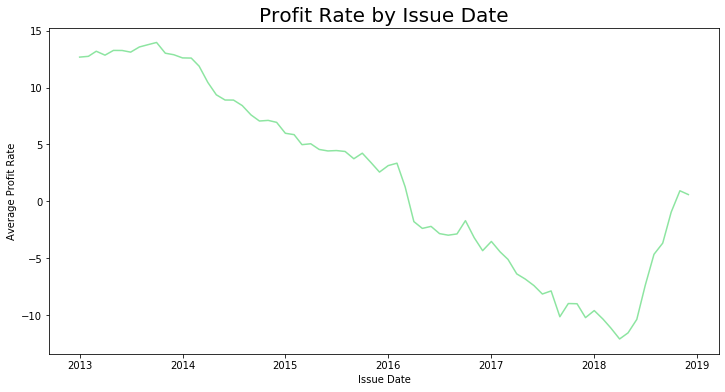

In [28]:
# default rate by Date
profit_rate = (accepted_new['total_pymnt'] - accepted_new['funded_amnt']) / accepted_new['funded_amnt'] * 100
date_agg = accepted_new.assign(profit_rate=profit_rate).groupby(['issue_d']).aggregate({'profit_rate':'mean'})
date_agg = date_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='issue_d', y='profit_rate', data=date_agg, color='g').set_title('Profit Rate by Issue Date', fontsize=20)

plt.xlabel("Issue Date")
plt.ylabel("Average Profit Rate")

plt.show()